Loading cleaned data...


C:\Users\nicar\AppData\Local\Temp\ipykernel_24152\844806528.py:29: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df_sorted.groupby("State")[col].pct_change() * 100
C:\Users\nicar\AppData\Local\Temp\ipykernel_24152\844806528.py:29: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df_sorted.groupby("State")[col].pct_change() * 100
C:\Users\nicar\AppData\Local\Temp\ipykernel_24152\844806528.py:29: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling p

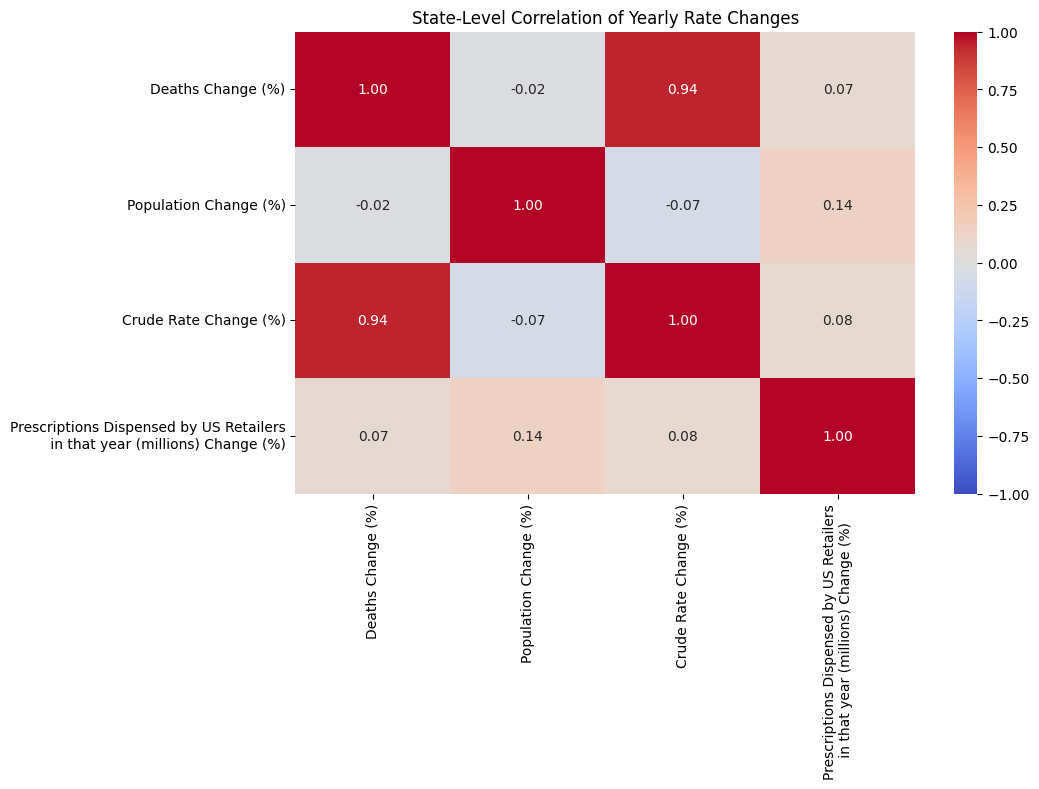

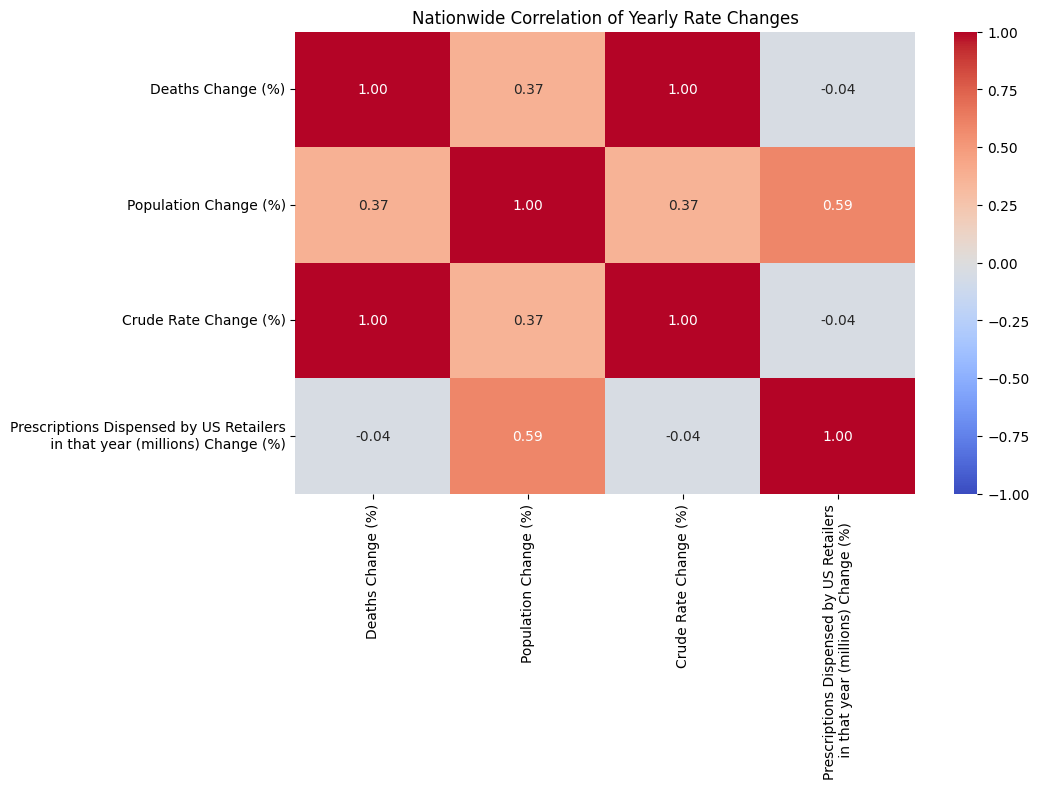

In [1]:
# Optimized Notebook: State-Level & Nationwide Correlation Analysis
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- Load Pre-Cleaned Data ---
print("Loading cleaned data...")
data_path = 'data/cleaned_multiple_cause_of_death.csv'
df = pd.read_csv(data_path)

# Convert necessary columns to numeric
numeric_columns = [
    "Deaths",
    "Population",
    "Crude Rate",
    "Crude Rate Lower 95% Confidence Interval",
    "Crude Rate Upper 95% Confidence Interval",
    "Prescriptions Dispensed by US Retailers in that year (millions)"
]
for col in numeric_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Ensure sorting by state and year
df_sorted = df.sort_values(by=["State", "Year"]).copy()

# Compute Year-over-Year percentage changes for state-level data
for col in numeric_columns:
    df_sorted[f"{col} Change (%)"] = (
        df_sorted.groupby("State")[col].pct_change() * 100
    )

# Drop rows with NaN values (the first year for each state)
df_change = df_sorted.dropna()

# --- Nationwide Aggregated Analysis ---
nationwide_data = []
for year, group in df.groupby("Year"):
    total_deaths = group["Deaths"].sum()
    total_population = group["Population"].sum()
    total_prescriptions = group[
        "Prescriptions Dispensed by US Retailers in that year (millions)"
    ].sum()
    
    # Compute weighted averages for crude rates
    weighted_crude_rate = (
        group["Crude Rate"] * group["Population"]
    ).sum() / total_population
    weighted_lower = (
        group["Crude Rate Lower 95% Confidence Interval"] * group["Population"]
    ).sum() / total_population
    weighted_upper = (
        group["Crude Rate Upper 95% Confidence Interval"] * group["Population"]
    ).sum() / total_population

    nationwide_data.append({
        "Year": year,
        "Deaths": total_deaths,
        "Population": total_population,
        "Prescriptions Dispensed by US Retailers in that year (millions)": total_prescriptions,
        "Crude Rate": weighted_crude_rate,
        "Crude Rate Lower 95% Confidence Interval": weighted_lower,
        "Crude Rate Upper 95% Confidence Interval": weighted_upper
    })

df_nationwide = pd.DataFrame(nationwide_data)

# Compute Year-over-Year percentage changes
for col in numeric_columns:
    df_nationwide[f"{col} Change (%)"] = (
        df_nationwide[col].pct_change() * 100
    )

# Drop first row (NaN from missing previous year)
df_nationwide_change = df_nationwide.dropna()

# --- Generate Correlation Heatmaps ---
# 1) Choose columns to keep (excludes 95% CI columns).
columns_to_keep = [
    "Deaths Change (%)",
    "Population Change (%)",
    "Crude Rate Change (%)",
    "Prescriptions Dispensed by US Retailers in that year (millions) Change (%)"
]

# 2) Rename map for the long column (use \n to split onto two lines).
rename_map = {
    "Prescriptions Dispensed by US Retailers in that year (millions) Change (%)":
        "Prescriptions Dispensed by US Retailers\n in that year (millions) Change (%)"
}

# ---------------------
# STATE-LEVEL CORRELATION
# ---------------------
df_change_subset = df_change[columns_to_keep].copy()
df_change_subset.rename(columns=rename_map, inplace=True)

# This will be our new ordered columns after renaming.
ordered_columns_state = df_change_subset.columns.tolist()

state_level_corr = df_change_subset.corr()
state_level_corr = state_level_corr.reindex(
    index=ordered_columns_state,
    columns=ordered_columns_state
)

plt.figure(figsize=(10, 6))
sns.heatmap(
    state_level_corr,
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    vmin=-1,
    vmax=1
)
plt.title("State-Level Correlation of Yearly Rate Changes")
plt.savefig("data/state_correlation_heatmap.png")
plt.show()

# ---------------------
# NATIONWIDE CORRELATION
# ---------------------
df_nationwide_subset = df_nationwide_change[columns_to_keep].copy()
df_nationwide_subset.rename(columns=rename_map, inplace=True)

ordered_columns_nationwide = df_nationwide_subset.columns.tolist()

nationwide_corr = df_nationwide_subset.corr()
nationwide_corr = nationwide_corr.reindex(
    index=ordered_columns_nationwide,
    columns=ordered_columns_nationwide
)

plt.figure(figsize=(10, 6))
sns.heatmap(
    nationwide_corr,
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    vmin=-1,
    vmax=1
)
plt.title("Nationwide Correlation of Yearly Rate Changes")
plt.savefig("data/nationwide_correlation_heatmap.png")
plt.show()
